# Utils Troubleshooting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from utils import *
pd.set_option('display.max_rows', 1000)

In [2]:
# DataFrame indices to give ~70,000 recipes from either recipe source
brewersfriend_indices = [330790, 403157]
brewtoad_indices = [258423, 330789]

In [3]:
# How close are we willing to consider our calculation of a field for it to be "ok"?
quality_cutoffs = {
    "og": 0.003,
    "fg": 0.003,
    "abv": 0.05,
    "ibu": 0.05, 
    "color": 0.05
}

In [4]:
def load_recipes(index_range):
    with pd.HDFStore("all_recipes.h5", "r") as store:
        where_clause = f"(index >= {index_range[0]}) & (index <= {index_range[1]})"
        core = store.select("/core", where=where_clause)
        ing = store.select("/ingredients", where=where_clause)
    df = core.join(ing)
    return df

In [5]:
def scale_ingreds(df):
    """Add columns for scaled ingredients to the DataFrame"""
    df["ferm_scaled"] = scale_ferm(df, "batch_size")
    df["hop_scaled"] = scale_hop(df, scale_volume_dry="batch_size", scale_volume_boil="batch_size") 
    return df

In [6]:
def calculate_metrics(df):
    """Add columns for the main beer measurements (IBU, SRM, ABV) to the DataFrame"""
    df["pbg"] = gravity_wort(df, scale_volume="boil_size")
    df["og"] = gravity_wort(df, scale_volume="batch_size")  
    df["fg"] = gravity_final(df)
    df["abv"] = abv(df)
    df["color"] = srm(df, ferm_col="ferm_scaled")
    df["ibu"] = ibu(df, hop_col="hop_scaled")
    return df

In [7]:
def quality_measure(col1, col2, cutoff=0.05):
    """
    Col1 is our calculated column (eg. "og")
    Col2 is the test column (eg. "og_est")
    Return a Series of Booleans showing if our calculation is within in the cutoff
    """
    is_field_ok = (abs(col1 - col2)/col2) < cutoff
    return is_field_ok

In [8]:
def add_quality_measures(df):
    for col in ["og", "fg", "abv", "ibu", "color"]:
        df[f"{col}_ok"] = quality_measure(df[col], df[f"src_{col}"], cutoff=quality_cutoffs[col])
    return df

In [9]:
def assess_quality(col1, col2):
    """
    Return measures of how close our calculated field is to the validation one (from the Brewersfriend set).
    
    Col1 is our calculated column (the Series itself)
    Col2 is the test column
    col_type is the string that defines 
    
    % of recipes that are "ok"
    mean difference in percent
    """
    col_ok = quality_measure(col1, col2, cutoff=quality_cutoffs[col1.name])
    recipe_ok = col_ok.groupby(col_ok.index).mean()
    pct_recipes_ok = recipe_ok.mean() 
    
    col_diff = col1 - col2
    avg_dff = col_diff.loc[recipe_ok.index].mean()
    avg_diff_ok = col_diff[recipe_ok].mean()
    avg_diff_not_ok = col_diff[~recipe_ok].mean()
    diff_dict = {"all": avg_dff, "ok": avg_diff_ok, "not_ok": avg_diff_not_ok}
    return pct_recipes_ok, diff_dict

In [10]:
def inspect_bad_recipes():
    pass

In [11]:
def plot_distribution(col1, col2=pd.DataFrame()):
    """
    Return a matplotlib fig with a nice plot of the distribution of the quantity.
    Optionally, also plot the distribution of a validation version of that quantity.
    """
    pass

In [12]:
df = load_recipes(brewersfriend_indices) 

In [13]:
df = scale_ingreds(df)

In [14]:
df = calculate_metrics(df)
df = add_quality_measures(df)

In [59]:
metrics_troubleshoot_cols = ["name", "boil_size", "batch_size", "efficiency", "src_og", "src_fg", "src_abv", "pbg", "og", "fg", "abv", "src_ibu","ibu", "src_color", "color"]

In [60]:
recipe_troubleshoot_cols =["name", "batch_size", "boil_size", "boil_time", "efficiency", "ferm_name", "ferm_amount", "ferm_yield", "ferm_potential"]

# Which ferm_types need different rules for efficiency?

In [105]:
df_friend = load_recipes(brewersfriend_indices) 
df_friend["ferm_type"].value_counts()

grain          237093
adjunct         22040
sugar           16908
dry extract     10098
extract          8163
Name: ferm_type, dtype: int64

In [106]:
df_toad = load_recipes(brewtoad_indices) 
df_toad["ferm_type"].value_counts()

caramel/crystal malt    58761
grain                   54451
adjunct                 48493
base malt               45292
kilned malt             35243
roasted malt            28558
sugar                   15266
liquid extract          15015
dry extract             14435
mash                       25
Name: ferm_type, dtype: int64

In [107]:
extract_types = ["adjunct", "sugar", "dry extract", "liquid extract", "extract"]

In [108]:
df_check = df_friend
df_check[df_check["ferm_type"].isin(extract_types)].groupby(["ferm_type", "ferm_name"])["batch_size"].count()

ferm_type    ferm_name                              
adjunct      flaked barley                              2733
             flaked corn                                1694
             flaked oats                                8277
             flaked rice                                 565
             flaked rye                                  896
             flaked wheat                               3521
             grits                                        48
             rice hulls                                 1820
             rolled barley                                 1
             rolled oats                                1074
             torrified barley                             66
             torrified wheat                            1345
dry extract  dry malt extract - amber                   1189
             dry malt extract - dark                     708
             dry malt extract - extra light             1228
             dry malt extract - 

In [120]:
df_check = df_toad
check_result = df_check[df_check["ferm_type"].isin(extract_types)].groupby(["ferm_type", "ferm_name"])["batch_size"].count()
check_result[check_result > 200].head(100)

ferm_type       ferm_name                        
adjunct         2-row carapils® malt                 1217
                acidulated malt                      1899
                american white wheat                  545
                barley, flaked                       1689
                carafoam                              489
                carapils                             2216
                carapils (dextrine malt)             2418
                carapils®                             389
                carapils® malt                       5280
                corn, flaked                          807
                flaked barley                        1108
                flaked corn                           663
                flaked oats                          3246
                flaked rice                           205
                flaked rye                            533
                flaked wheat                         1524
                golden

Don't include the "adjunct" values for ferm_type!

# What's the improvement in OG from fixing too-low efficiency values? 

In [15]:
acceptable_efficiency = [0.5, 1]

In [16]:
def split_series_on_range(series, min_value, max_value):
    inside_mask = series.between(min_value, max_value)
    inside = series[inside_mask]
    outside = series[~inside_mask]
    return inside, outside

In [17]:
def replace_with_mean(efficiency, acceptable_min=0.5, acceptable_max=1.0):
    """ Replace the bad efficiencies with the mean good efficiency """
    acceptable_efficiency, unacceptable_efficiency = split_series_on_range(efficiency, acceptable_min, acceptable_max)
    mean_acceptable_efficiency = acceptable_efficiency.groupby(acceptable_efficiency.index).first().mean()
    new_efficiency = acceptable_efficiency.append(pd.Series(index=unacceptable_efficiency.index, data=mean_acceptable_efficiency))
    return new_efficiency.sort_index()

In [18]:
def replace_with_double(efficiency, acceptable_min=0.5, acceptable_max=1.0):
    """ Replace the bad efficiencies with double their value """
    acceptable_efficiency, unacceptable_efficiency = split_series_on_range(efficiency, acceptable_min, acceptable_max)
    doubled_efficiency = unacceptable_efficiency * 2    
    new_efficiency = acceptable_efficiency.append(pd.Series(index=unacceptable_efficiency.index, data=doubled_efficiency))
    return new_efficiency.sort_index()

In [19]:
def replace_with_diff_from_one(efficiency, acceptable_min=0.5, acceptable_max=1.0):
    """ Replace the bad efficiencies with the difference between them and 1 """
    acceptable_efficiency, unacceptable_efficiency = split_series_on_range(efficiency, acceptable_min, acceptable_max)
    diff_from_one_efficiency = 1 - unacceptable_efficiency
    new_efficiency = acceptable_efficiency.append(pd.Series(index=unacceptable_efficiency.index, data=diff_from_one_efficiency))
    return new_efficiency.sort_index()

In [20]:
df["eff_mean"] = replace_with_mean(df["efficiency"])
df["eff_double"] = replace_with_double(df["efficiency"])
df["eff_diff"] = replace_with_diff_from_one(df["efficiency"])

In [21]:
def gravity_og_test(df, eff_col, eff_factor=1):
    """
    TESTING ONLY
    """
    ferm_scaled = scale_ferm(df, "batch_size") 

    # ferm_extract_yield
    # Multiply by 100 to get from fraction to plato (which is percentage)
    fey = ferm_scaled * df["ferm_yield"] * eff_factor * df[eff_col] * 100
    return 1 + 0.004 * fey.groupby(fey.index).sum()

In [22]:
df["og_mean"] = gravity_og_test(df, "eff_mean")
df["og_double"] = gravity_og_test(df, "eff_double")
df["og_diff"] = gravity_og_test(df, "eff_diff")

In [23]:
df["og_mean"].describe()

count    373875.000000
mean          1.066886
std           0.552688
min           1.000000
25%           1.052037
50%           1.060220
75%           1.070928
max          94.511423
Name: og_mean, dtype: float64

In [24]:
def plot_hexbin_gravity_dist(col_test):
    """ Display a plot of a hexbin distribution betwen the test column and est_og """
    value_min = 1.0
    value_max = 1.1
    fig = plt.figure(figsize=[16,12])
    ax = fig.add_subplot(111)
    ax.set_title(f"{col_test} vs src_og")
    colormap = ax.hexbin(df[col_test].values, df["src_og"].values, extent=[value_min, value_max, value_min, value_max], mincnt=10, norm=LogNorm())
    ax.plot([1, 2], [1, 3], color="tomato", lw=3)
    ax.plot([1, 2], [1, 2], color="tomato", lw=3)
    ax.plot([1, 2], [1, 1.5], color="tomato", lw=3)
    ax.set_xlim([value_min, value_max])
    ax.set_ylim([value_min, value_max])
    ax.set_xlabel(col_test)
    ax.set_ylabel("src_og")
    fig.colorbar(colormap)
    plt.show()

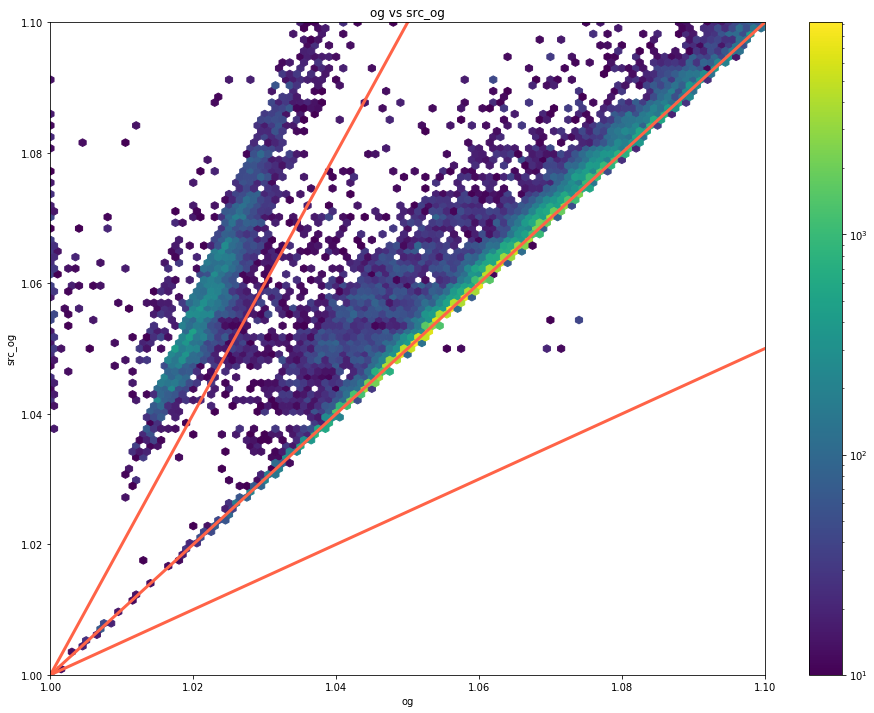

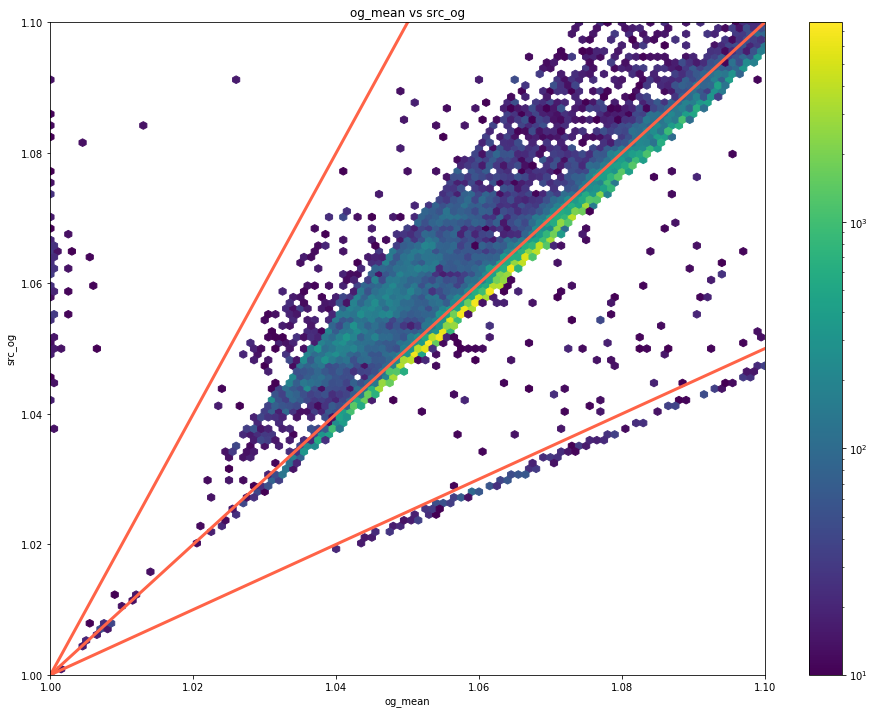

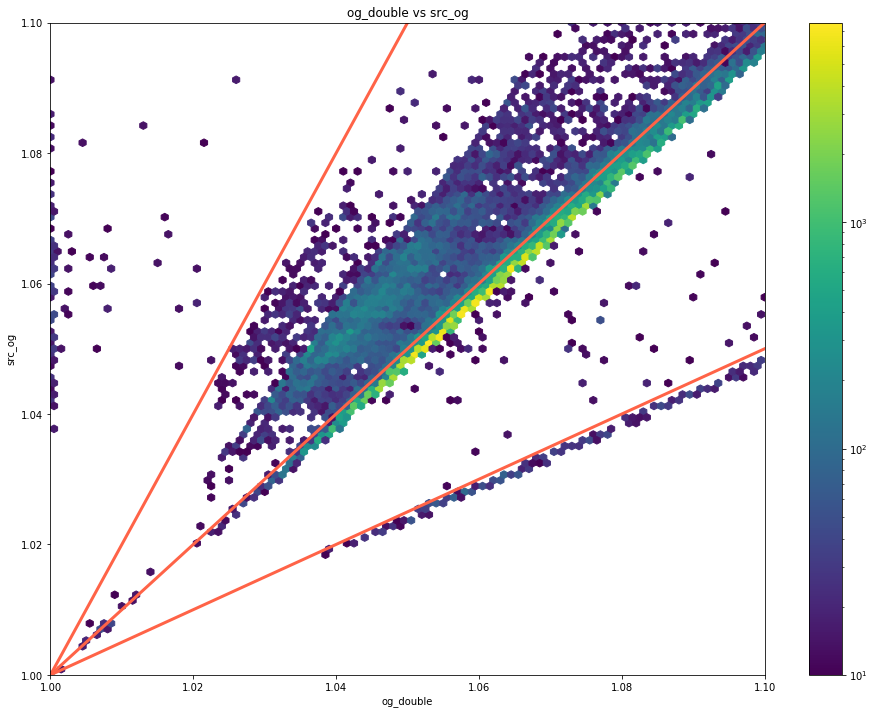

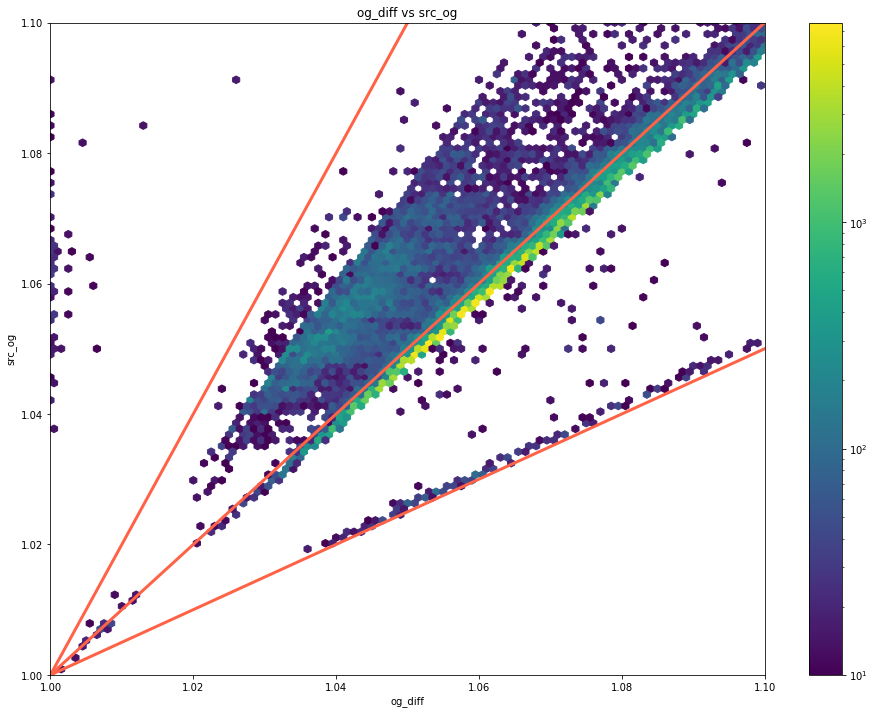

In [97]:
for col_test in ["og", "og_mean", "og_double", "og_diff"]:
    plot_hexbin_gravity_dist(col_test)

Looks like replacing bad efficiencies with the mean is the best and simplest approach

# What's the improvement in OG by correcting for moisture?

What's the effect of introducing a 4% efficiency drop to account for moisture?
Moisture typically accounts for 4% of the weight of a grain! Source: https://www.brewersfriend.com/2012/11/30/making-sense-of-efficiency-definitions/

In [83]:
df["og_mean_moist_adjust"] = gravity_og_test(df, "eff_mean", 0.96)

Testing OG calculations based on efficiency moisture correction: og_mean


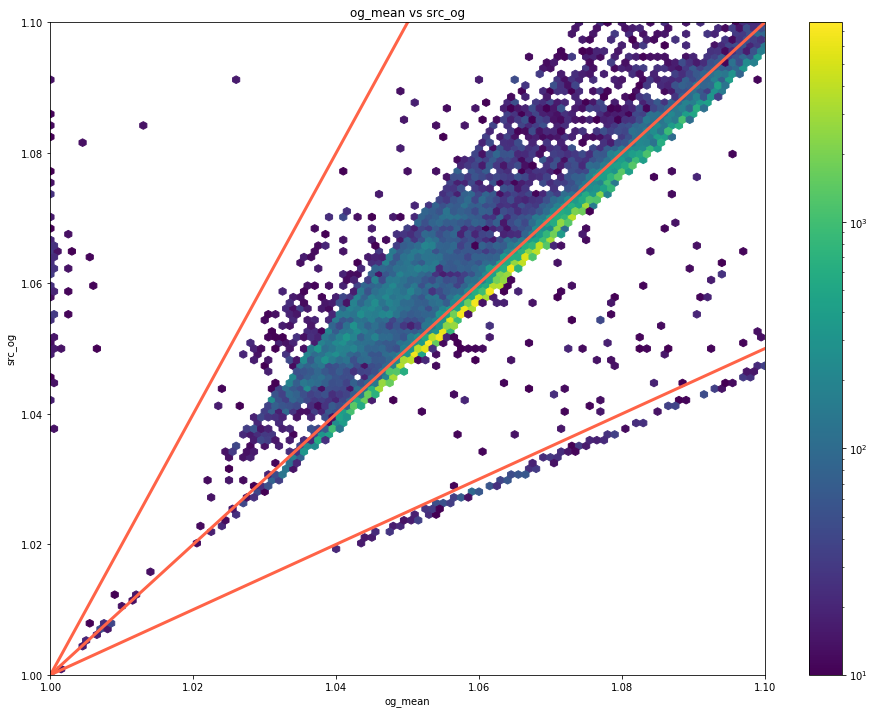

Testing OG calculations based on efficiency moisture correction: og_mean_moist_adjust


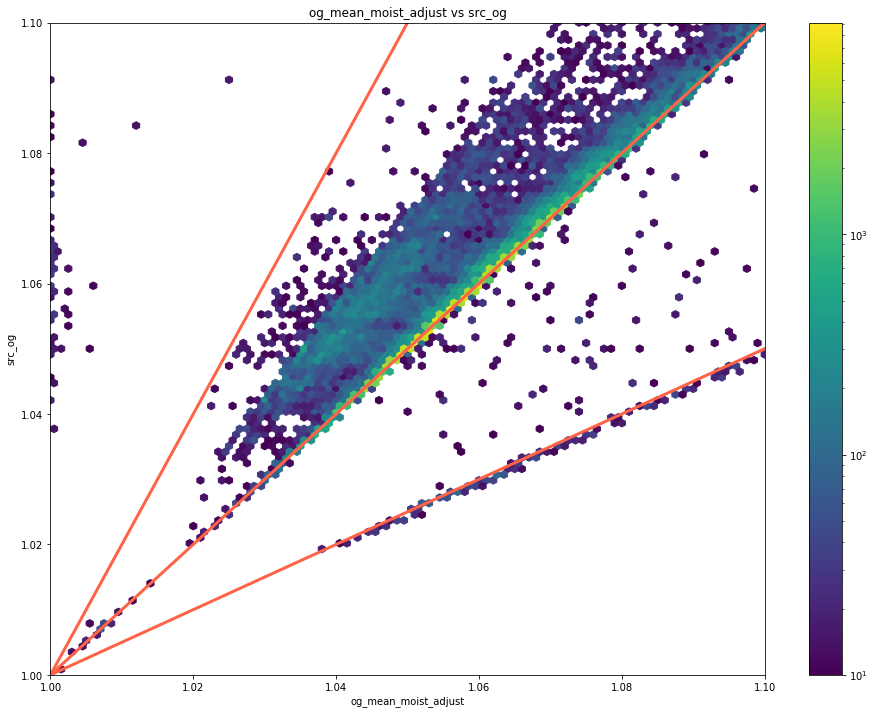

In [84]:
for col_test in ["og_mean", "og_mean_moist_adjust"]:
    print(f"Testing OG calculations based on efficiency moisture correction: {col_test}")
    plot_hexbin_gravity_dist(col_test)

# Which OGs are off because ferm_yield == 0?

How many of the recipes that are off have ferm_yield = 0?

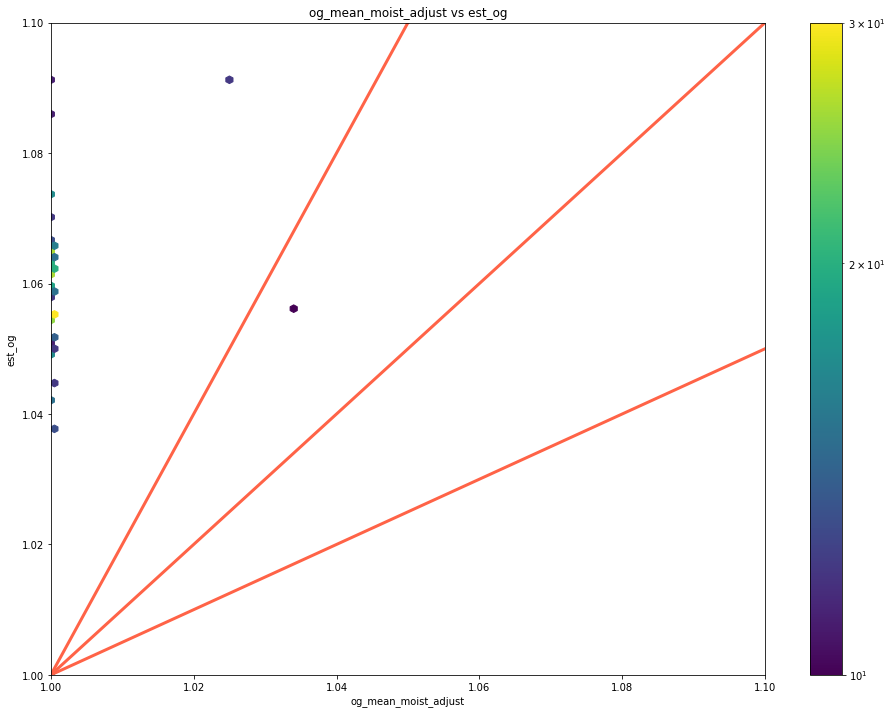

In [63]:
df_zero_yield = df[(df["ferm_yield"] == 0) & (df["ferm_name"] != "rice hulls") ]
col_test = "og_mean_moist_adjust"

value_min = 1.0
value_max = 1.1
fig = plt.figure(figsize=[16,12])
ax = fig.add_subplot(111)
ax.set_title(f"{col_test} vs est_og")
colormap = ax.hexbin(df_zero_yield[col_test].values, df_zero_yield["est_og"].values, extent=[value_min, value_max, value_min, value_max], mincnt=10, norm=LogNorm())
ax.plot([1, 2], [1, 3], color="tomato", lw=3)
ax.plot([1, 2], [1, 2], color="tomato", lw=3)
ax.plot([1, 2], [1, 1.5], color="tomato", lw=3)
ax.set_xlim([value_min, value_max])
ax.set_ylim([value_min, value_max])
ax.set_xlabel(col_test)
ax.set_ylabel("est_og")
fig.colorbar(colormap)
plt.show()

How many of the recipes have dry malt extract or dextrose?

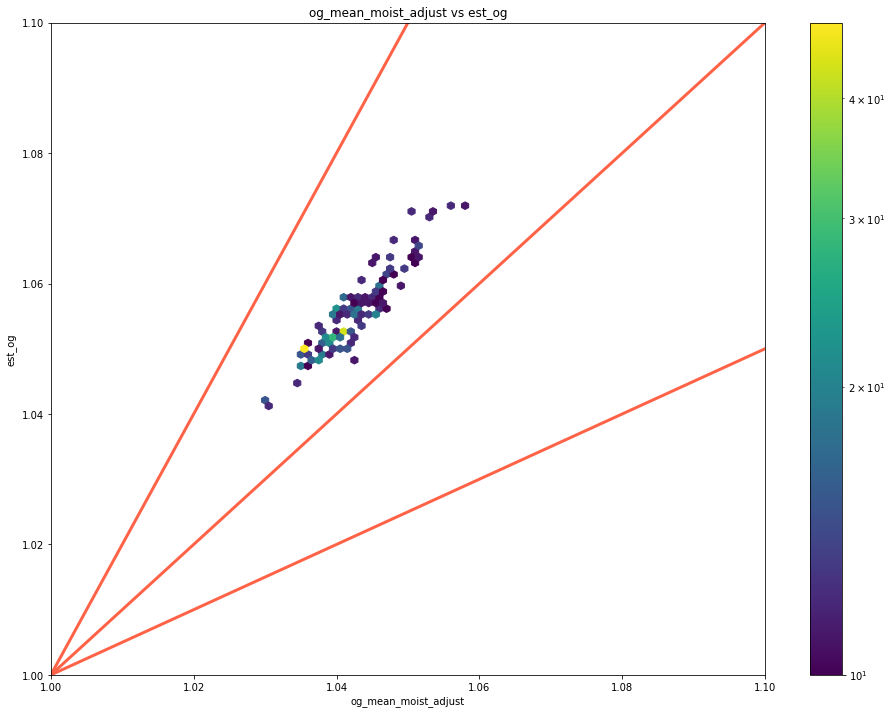

In [74]:
df_zero_yield = df[df["ferm_name"] == "dry malt extract - light"]
col_test = "og_mean_moist_adjust"

value_min = 1.0
value_max = 1.1
fig = plt.figure(figsize=[16,12])
ax = fig.add_subplot(111)
ax.set_title(f"{col_test} vs est_og")
colormap = ax.hexbin(df_zero_yield[col_test].values, df_zero_yield["est_og"].values, extent=[value_min, value_max, value_min, value_max], mincnt=10, norm=LogNorm())
ax.plot([1, 2], [1, 3], color="tomato", lw=3)
ax.plot([1, 2], [1, 2], color="tomato", lw=3)
ax.plot([1, 2], [1, 1.5], color="tomato", lw=3)
ax.set_xlim([value_min, value_max])
ax.set_ylim([value_min, value_max])
ax.set_xlabel(col_test)
ax.set_ylabel("est_og")
fig.colorbar(colormap)
plt.show()

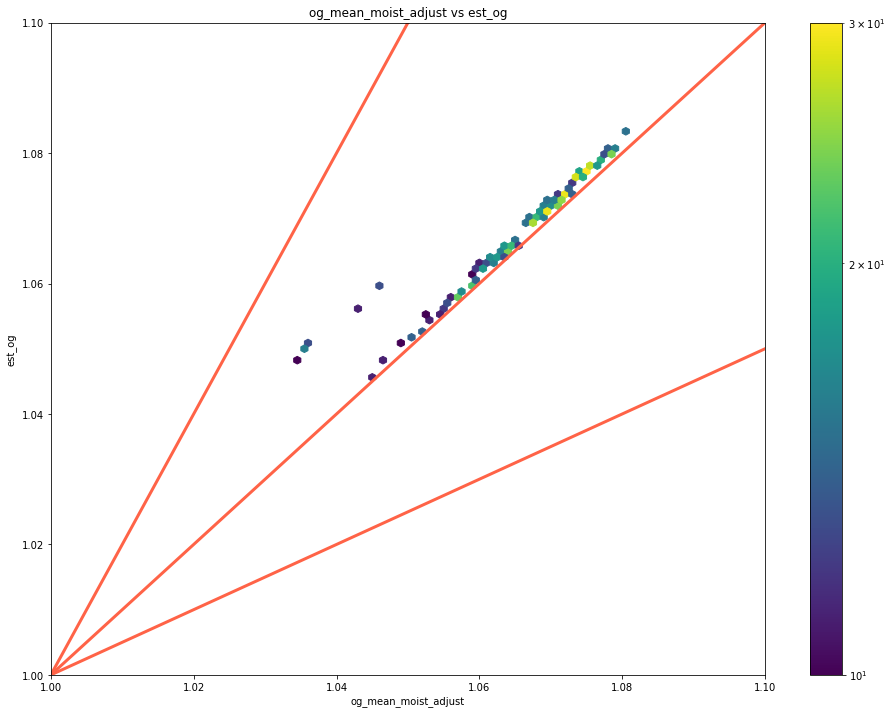

In [76]:
df_zero_yield = df[df["ferm_name"] == "corn sugar - dextrose"]
col_test = "og_mean_moist_adjust"

value_min = 1.0
value_max = 1.1
fig = plt.figure(figsize=[16,12])
ax = fig.add_subplot(111)
ax.set_title(f"{col_test} vs est_og")
colormap = ax.hexbin(df_zero_yield[col_test].values, df_zero_yield["est_og"].values, extent=[value_min, value_max, value_min, value_max], mincnt=10, norm=LogNorm())
ax.plot([1, 2], [1, 3], color="tomato", lw=3)
ax.plot([1, 2], [1, 2], color="tomato", lw=3)
ax.plot([1, 2], [1, 1.5], color="tomato", lw=3)
ax.set_xlim([value_min, value_max])
ax.set_ylim([value_min, value_max])
ax.set_xlabel(col_test)
ax.set_ylabel("est_og")
fig.colorbar(colormap)
plt.show()

# What is the improvement in OG after correcting efficiency by implementing rules for ferm_type?

In [70]:
df["efficiency"] = replace_with_mean(df["efficiency"])
df["eff_adjusted"] = adjust_efficiency(df, sugar_efficiency=1, lme_efficiency=1)

In [71]:
def gravity_wort_test_efficiency_adjust(df, efficiency_col, scale_volume="batch_size"):
    """
    TEST
    """
    ferm_scaled = scale_ferm(df, scale_volume)

    # ferm_extract_yield
    # Multiply by 100 to get from fraction to plato (which is percentage)
    fey = ferm_scaled * df["ferm_yield"] * df[efficiency_col] * 0.96 * 100
    return 1 + 0.004 * fey.groupby(fey.index).sum()

In [72]:
df["og_eff_adjusted"] = gravity_wort_test_efficiency_adjust(df, efficiency_col="eff_adjusted", scale_volume="batch_size")

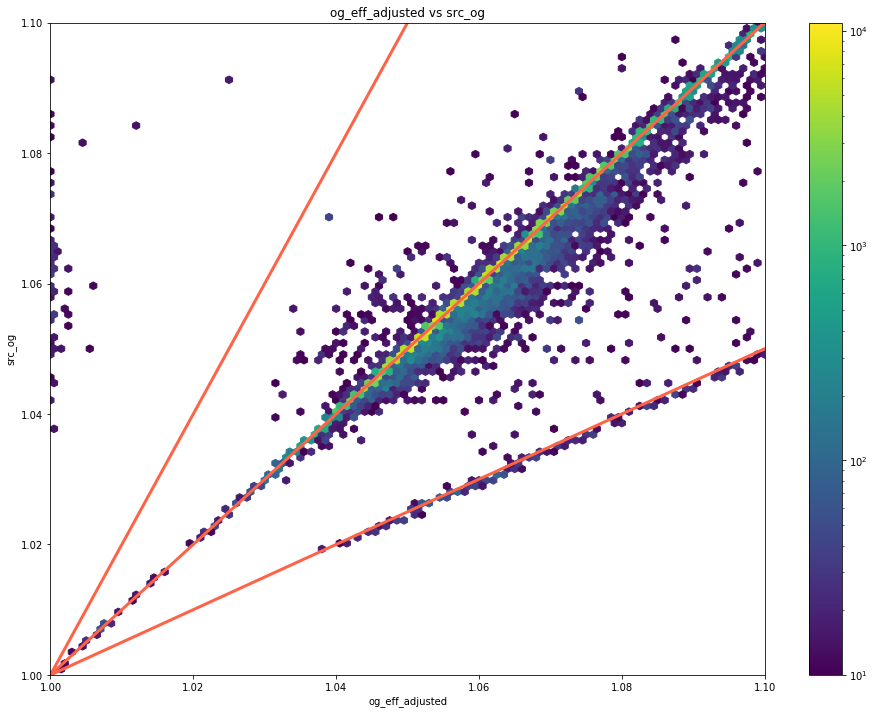

In [96]:
plot_hexbin_gravity_dist("og_eff_adjusted")

# What's the improvement in OG after correcting ferm_yield == 0?

In [81]:
ferm_yield_mean = df[df["ferm_yield"] != 0].groupby("ferm_type")["ferm_yield"].mean()
ferm_yield_mean

ferm_type
adjunct        0.742587
dry extract    0.914883
extract        0.764420
grain          0.758122
sugar          0.915080
Name: ferm_yield, dtype: float64

In [104]:
bad_ferm_yield_ind = df[(df["ferm_yield"] == 0) & (df["ferm_name"] != "rice hulls")].index
df["ferm_yield_adjusted"] = df["ferm_yield"]
df.loc[bad_ferm_yield_ind, "ferm_yield_adjusted"] = df.loc[bad_ferm_yield_ind, "ferm_type"].map(ferm_yield_mean)

In [92]:
df[~df["ferm_name"].isna()].loc[bad_ferm_yield_ind][["ferm_name", "ferm_yield", "ferm_yield_adjusted"]].head(5)

,ferm_name,ferm_yield,ferm_yield_adjusted
id,,,
330883,barley (flaked),0.0,0.758122
330883,munich (light),0.0,0.758122
330883,crystal 10l,0.0,0.758122
330883,malt - amber,0.0,0.758122
330883,barley (flaked),0.0,0.758122


In [93]:
def gravity_wort_test_eff_yield(df, efficiency_col, yield_col, scale_volume="batch_size"):
    """
    TEST
    """
    ferm_scaled = scale_ferm(df, scale_volume)

    # ferm_extract_yield
    # Multiply by 100 to get from fraction to plato (which is percentage)
    fey = ferm_scaled * df[yield_col] * df[efficiency_col] * 0.96 * 100
    return 1 + 0.004 * fey.groupby(fey.index).sum()

In [94]:
df["og_eff_yield_adj"] = gravity_wort_test_eff_yield(df, efficiency_col="eff_adjusted", yield_col="ferm_yield_adjusted", scale_volume="batch_size")

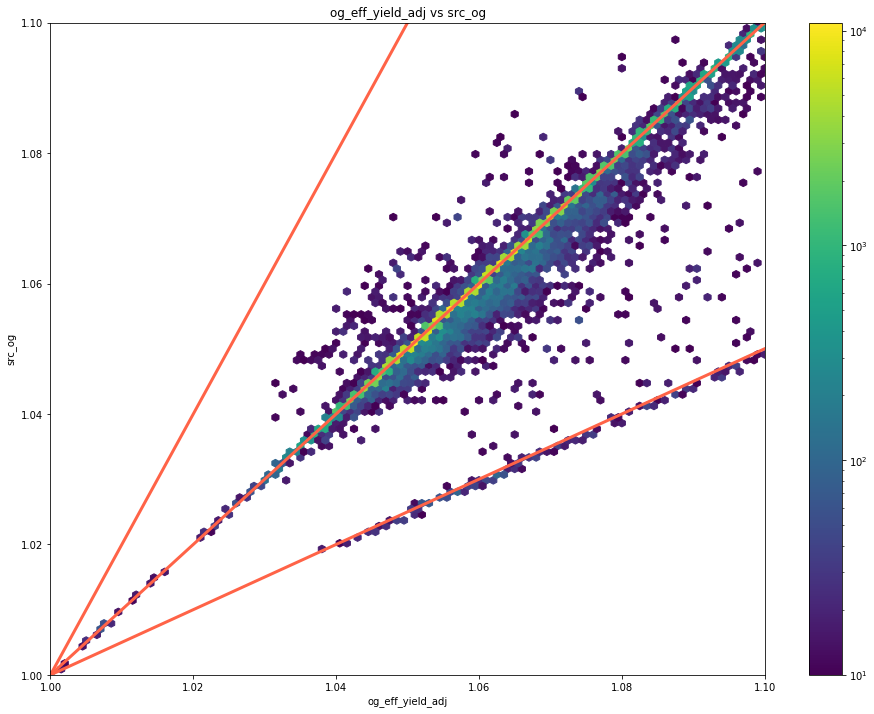

In [95]:
plot_hexbin_gravity_dist("og_eff_yield_adj")

What recipes does Brewersfriend still give a much LOWER OG than we do?

## (Old) How does the quality of our OG and ABV fields depend on efficiency?

In [19]:
def count_true(gb):
    d = {
        "ok": gb.sum(),
    }
    return pd.Series(d)

In [20]:
def count_false(gb):
    d = {
        "not_ok": len(gb) - gb.sum(),
    }
    return pd.Series(d)

In [21]:
df.columns

Index(['batch_size', 'boil_size', 'boil_time', 'brewer', 'efficiency',
       'est_abv', 'est_color', 'est_fg', 'est_ibu', 'name', 'est_og', 'origin',
       'recipe_file', 'style_category', 'style_guide', 'style_name',
       'style_version', 'ferm_amount', 'ferm_color', 'ferm_display_amount',
       'ferm_name', 'ferm_origin', 'ferm_potential', 'ferm_yield', 'hop_alpha',
       'hop_amount', 'hop_display_amount', 'hop_form', 'hop_name',
       'hop_origin', 'hop_time', 'hop_use', 'misc_amount',
       'misc_amount_is_weight', 'misc_name', 'misc_time', 'misc_use',
       'yeast_amount', 'yeast_attenuation', 'yeast_flocculation', 'yeast_form',
       'yeast_laboratory', 'yeast_name', 'yeast_product_id', 'yeast_type',
       'hop_scaled_boil', 'hop_scaled_batch', 'ferm_scaled_boil',
       'ferm_scaled_batch', 'ferm_scaled', 'pbg', 'og', 'fg', 'color', 'ibu',
       'abv', 'og_ok', 'fg_ok', 'ibu_ok', 'abv_ok', 'color_ok'],
      dtype='object')

In [22]:
metric_to_test = "abv"
ok_cols = ["og_ok", "fg_ok", "abv_ok"]
ok_counts = df.groupby(["efficiency"])[ok_cols].agg({"ok": count_true, "not_ok": count_false})

/Users/rwelch/code_home/beer.ai/env/lib/python3.8/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [23]:
ok_counts

ok              not_ok             
           og_ok fg_ok abv_ok  og_ok fg_ok abv_ok
efficiency                                       
0.0000         0     0      0     27    27     27
0.0100         0     0      0      4     4      4
0.0500         0     0      0     11    11     11
0.0660         5     5      0      0     0      5
0.1000         0     1      0     12    11     12
0.1500         0     0      0      6     6      6
0.2000         0     0      0      6     6      6
0.2200         0     0      0      6     6      6
0.2300         0     0      0      4     4      4
0.2500         2     2      0     90    90     92
0.3000         0     0      0     55    55     55
0.3200         4     4      4      0     0      0
0.3300         3     3      3      0     0      0
0.3500       170   244    126   2205  2131   2249
0.4000         0     0      0     38    38     38
0.4200         7    14      7      7     0      7
0.4450         8     8      8      0     0      0
0.4500        13    29     22     35    19     26
0.4700         7     7      7     11    11     11
0.4900         8     8      8      0     0      0
0.5000       144   176    129    170   138    185
0.5100        14    14     14      0     0      0
0.5200         0     5      5      5     0      0
0.5240         3     3      3      0     0      0
0.5300        11    18      4      7     0     14
0.5400        18    25     12      7     0     13
0.5450         0     0      0      6     6      6
0.5500       121   130     97     13     4     37
0.5550         9     9      9      0     0      0
0.5600        25    25     19      4     4     10
0.5700        25    25     18      0     0      7
0.5750         7     7      0      0     0      7
0.5800        74    68     68      0     6      6
0.5850        11    11      0      0     0     11
0.5880         4     4      4      0     0      0
0.5900        19    22     18      3     0      4
0.6000       871   947    805    196   120    262
0.6100        76    68     68      4    12     12
0.6120         9     9      9      0     0      0
0.6200       176   206    180     30     0     26
0.6250        12    12     12      0     0      0
0.6300       171   176    145     31    26     57
0.6350         9     9      9      0     0      0
0.6400        66    62     54      6    10     18
0.6500      1560  1674   1483    311   197    388
0.6600        95    86     82      0     9     13
0.6700       204   233    201     39    10     42
0.6710         4     4      4      0     0      0
0.6800       421   431    415     51    41     57
0.6850         4     4      4      0     0      0
0.6867         4     4      4      0     0      0
0.6900       132   132    109     20    20     43
0.7000      5860  6392   5426   1090   558   1524
0.7050         4     4      0      0     0      4
0.7100       183   187    145     10     6     48
0.7130         0     5      5      5     0      0
0.7200       764   769    672     84    79    176
0.7250        21    21     21      0     0      0
0.7300       357   376    328     50    31     79
0.7400       200   213    196     19     6     23
0.7500      3710  4171   3577    742   281    875
0.7600       124   134    109     10     0     25
0.7650         4     4      0      0     0      4
0.7700       201   203    167     10     8     44
0.7781         5     5      5      0     0      0
0.7800       370   389    337     48    29     81
0.7820         4     4      4      0     0      0
0.7900        81    85     79     15    11     17
0.8000      1112  1148    980    107    71    239
0.8010         0     5      5      5     0      0
0.8100        35    42     39      7     0      3
0.8200       107    90     92     16    33     31
0.8210         6     6      6      0     0      0
0.8300        51    73     73     22     0      0
0.8400        51    63     50     17     5     18
0.8500       323   362    318     44     5     49
0.8510         5     5      5      0     0      0
0.8600        

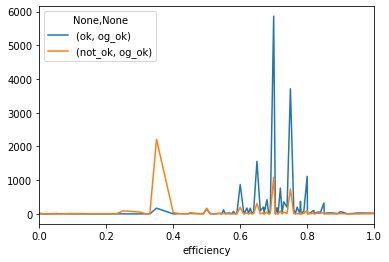

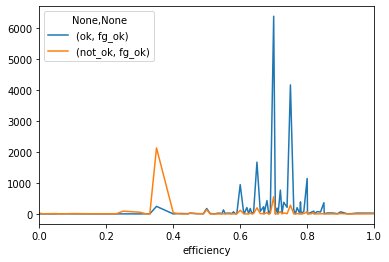

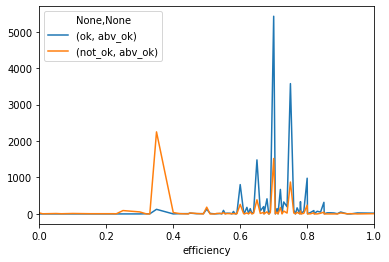

In [258]:
for col in ok_cols:
    ok_counts[[("ok",col), ("not_ok", col)]].plot()